# Download and plot liquid freshwater discharge

#### Notes from the paper:

"Freshwater  discharge  from  Greenland  primarily  takes three  forms: <br>
1) solid  ice  from  calving  at  marine-terminating glaciers <br>
2) submarine  meltwater  from  ice–ocean  boundary melting  at  marine-terminating  glaciers <br>
3) liquid  runoff from melted inland surface ice, rain, and condensation." <br>

1 and 2 are included in the solid ice discharge dataset and 3 is covered in the liquid discharge dataset plotted here

Runoff, R, is defined by: <br>
R = ME + RA − RT − RF. (1) <br>
In Eq. (1), ME is melt, RA is rainfall, RT is retention, and RF is refreezing.
Runoff
is assigned an uncertainty of ± 15 % (Sect. 4.3.3).

– **Runoff** refers to the unmodified RCM data products – melted ice, rain, condensation, and evaporation – that comprise the RCM runoff output variable.<br>
– **Discharge** refers to the runoff after it has been processed by this work – routed to and aggregated at the outlets. Depending on context, discharge may also refer to the observed stream discharge (Table 1).

"Both this product and Mankoff et al. (2020) provide liquid or solid freshwater volume flow rates at outlets (this product) or grounding lines (Mankoff et al., 2020), but actual fresh- water  discharge  into  a  fjord  occurs  at  a  more  complicated range of locations. Solid ice melts throughout the fjord and beyond (e.g., Enderlin et al., 2016; Moon et al., 2017), and the freshwater discharge presented here may enter at the re- ported depth (Sect. 4.3.6) but rapidly rises up the ice front and  eventually  flows  into  the  fjord  at  some  isopycnal  (see Mankoff et al., 2016). The eventual downstream location of the fresh water is not addressed in this work."

**there are temporal errors associated with this product**: <br>
"From this, the product is more appropriately used to estimate the magnitude of the discharge from any individ- ual basin, and perhaps provide some idea of the statisti- cal variability, but not necessarily the precise amount of discharge for any specific day, because routing delays are neglected."

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
from matplotlib import cm
from pyproj import Proj, transform, Transformer, CRS
from matplotlib.colors import ListedColormap
import geopandas
# for progress bar
from tqdm.notebook import tqdm_notebook

Code and README: https://github.com/GEUS-Glaciology-and-Climate/freshwater <br>
Data: https://doi.org/10.22008/promice/freshwater

https://dataverse.geus.dk/dataset.xhtml?persistentId=doi:10.22008/FK2/AA6MTB

run these lines of code in GitBash (cat is a UNIX command, not available on Windows but will work using GitBash on a windows machine)
>wget https://dataverse.geus.dk/api/datasets/:persistentId?persistentId=doi:10.22008/FK2/AA6MTB -O tmp.json

>cat tmp.json | tr ',' '\n' | grep -E '"persistentId"|"directoryLabel"|"filename"' | cut -d'"' -f4 > urls.txt

Run this loop to download each file using the filenames in the urls.txt file

## Download files

In [ ]:
# identify directory for where to save files
# download_root_dir = '../../../data/Mankoff_discharge/liquid_discharge/freshwater/'
download_root_dir = 'D:/Mankoff_discharge_data/liquid_discharge/freshwater/' # external harddrive with 'OMG_Narwhals' sticker

# open .txt file that was created using Ken's bash parsing code (above)
f = open('C:/Users/marie/urls.txt').read().split()

# loop to open urls.txt file and iterate through dir, doi, filename using wget to download the file
for i in np.arange(0,len(f),3): # go through every 3 lines
    file_info = f[i:i+3]
    print(file_info)
    # isolate each
    file_dir = file_info[0] + '/'
    doi = file_info[1]
    filename = file_info[2]
    # download file using wget command
    !wget https://dataverse.geus.dk/api/access/datafile/:persistentId?persistentId={doi} -O {download_root_dir + file_dir + filename}

## Define functions to query NetCDF files

Each basin (land or ice) supplies freshwater to the determined outlet locations (1 for each basin). Outlets that cover the main upstream drainage basin associated with a particular fjord are summed and plotted.

**Mouginot (2019) and Bjørk (2015) names for our three fjords:** <br>
KONG_OSCAR_GLETSCHER (Nuussuup Sermia) <br>
RINK_GLETSCHER (Rink Gletsjer) <br>
SVERDRUP_GLETSCHER (Sverdrup Gletsjer) 

In [2]:
def get_freshwater_discharge_data(data_dir, output_dir, get_years=['2019'], station_name='Rink Gletsjer', range_filter='TRUE', range_meters=8000):
    """
    Function that opens and combines multiple years of RACMO and MAR freshwater discharge data (land and ice) for a specific
    glacier basin ('station_name'), using Bjørk (2015) official names. 
    
    If range_filter='TRUE', discharge data will be filtered for outlets within the specified range ('range_meters') from the glacier basin.
    
    Returns two datasets, 'racmo_discharge_ds' and 'mar_discharge_ds,' which include land and ice freshwater discharge estimates from RACMO and MAR 
    regional climate models, respectively.
    
    saves netcdfs of these two datasets in 'output_dir'
    """
    for i in tqdm_notebook(range(len(get_years)), desc='query netcdfs'):     
        # open datasets
        racmo_ice_ds = xr.open_dataset(discharge_data_dir + '/ice/discharge/RACMO_' + get_years[i] +  '.nc')
        mar_ice_ds   = xr.open_dataset(discharge_data_dir + '/ice/discharge/MAR_' + get_years[i] +  '.nc')
        racmo_land_ds = xr.open_dataset(discharge_data_dir + '/land/discharge/RACMO_' + get_years[i] +  '.nc')
        mar_land_ds   = xr.open_dataset(discharge_data_dir + '/land/discharge/MAR_' + get_years[i] +  '.nc')
        
        # query datasets for station (glacier) and distance of outlets from glacier basin
        tmp_racmo_ice  = racmo_ice_ds.where(racmo_ice_ds.B2015_name==station_name, drop=True)
        tmp_mar_ice    = mar_ice_ds.where(mar_ice_ds.B2015_name==station_name, drop=True)
        tmp_racmo_land = racmo_land_ds.where(racmo_land_ds.B2015_name==station_name, drop=True)
        tmp_mar_land   = mar_land_ds.where(mar_land_ds.B2015_name==station_name, drop=True)
        
        if range_filter=='TRUE':
            tmp_racmo_ice  = tmp_racmo_ice.where(tmp_racmo_ice.B2015_dist<range_meters, drop=True)
            tmp_mar_ice    = tmp_mar_ice.where(tmp_mar_ice.B2015_dist<range_meters, drop=True) 
            tmp_racmo_land = tmp_racmo_land.where(tmp_racmo_land.B2015_dist<range_meters, drop=True)
            tmp_mar_land   = tmp_mar_land.where(tmp_mar_land.B2015_dist<range_meters, drop=True)
        
        # reassign B2015_dist as a coordinate for option to index by this later
        racmo_ice_all  = tmp_racmo_ice.discharge.assign_coords(B2015_dist=('station', tmp_racmo_ice.B2015_dist.values))
        mar_ice_all    = tmp_mar_ice.discharge.assign_coords(B2015_dist=('station', tmp_mar_ice.B2015_dist.values))
        racmo_land_all = tmp_racmo_land.discharge.assign_coords(B2015_dist=('station', tmp_racmo_land.B2015_dist.values))
        mar_land_all   = tmp_mar_land.discharge.assign_coords(B2015_dist=('station', tmp_mar_land.B2015_dist.values))
        
        if i==0:
            racmo_ice_tmp  = racmo_ice_all.copy(deep=True)
            mar_ice_tmp    = mar_ice_all.copy(deep=True) 
            racmo_land_tmp = racmo_land_all.copy(deep=True)
            mar_land_tmp   = mar_land_all.copy(deep=True)
        else:
            racmo_ice_tmp  =  xr.concat([racmo_ice_tmp, racmo_ice_all], dim='time')
            mar_ice_tmp    =  xr.concat([mar_ice_tmp, mar_ice_all], dim='time')
            racmo_land_tmp =  xr.concat([racmo_land_tmp, racmo_land_all], dim='time')
            mar_land_tmp   =  xr.concat([mar_land_tmp, mar_land_all], dim='time')
        
        # combine land and ice datasets with new dimension and coordinates
        racmo_discharge_ds = xr.concat([racmo_ice_tmp, racmo_land_tmp], 'basin_type').assign_coords(basin_type=['ice', 'land'])
        mar_discharge_ds = xr.concat([mar_ice_tmp, mar_land_tmp], 'basin_type').assign_coords(basin_type=['ice', 'land'])
    
    filename = station_name.split()[0] + '_' + station_name.split()[1] +'.nc'
    racmo_discharge_ds.to_netcdf(output_dir + '/racmo_freshwater_discharge_' + filename)
    mar_discharge_ds.to_netcdf(output_dir + '/mar_freshwater_discharge_' + filename)
    
    return racmo_discharge_ds, mar_discharge_ds

In [3]:
# function that reprojects lat/lon coordinates to polar stereographic
# lat/lon coordinates are needed in the functions below
def transform_projection_to_Npolar(line_da):
    transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3413', always_xy=True)
    xx, yy = transformer.transform(line_da.lon.values, line_da.lat.values)
    return xx,yy

### Define directories

In [4]:
discharge_data_dir = 'D:/Mankoff_discharge_data/liquid_discharge/freshwater'

In [5]:
output_dir = 'netcdfs'

### Import data

In [53]:
# import bathymetry data
bedmachine_ds = xr.open_dataset('../../data/bathymetry/BedMachine_v5_regions/bedmachineV5_moorings_region.nc')

In [54]:
# create mask for only bathymetry values less than zero (below surface) - set values > 0 to zero.
bed_masked_ds = bedmachine_ds.bed.where(bedmachine_ds.bed<0, 0)

In [55]:
# import basin shapefiles
basins_ice = geopandas.read_file(discharge_data_dir + '/ice/basins.gpkg')
basins_land = geopandas.read_file(discharge_data_dir + '/land/basins.gpkg')

## Run functions

### Rink glacier

In [ ]:
rink_racmo_ds, rink_mar_ds = get_freshwater_discharge_data(discharge_data_dir, output_dir, get_years=['2018','2019','2020'],\
                                                           station_name='Rink Gletsjer', range_filter='FALSE', range_meters=8000)

In [7]:
# load data
rink_racmo_ds = xr.open_dataset('D:/Habitat_model_data/Mankoff_discharge_data/netcdfs/racmo_freshwater_discharge_Rink_Gletsjer.nc')
rink_mar_ds = xr.open_dataset('D:/Habitat_model_data/Mankoff_discharge_data/netcdfs/mar_freshwater_discharge_Rink_Gletsjer.nc')

In [9]:
# reproject lat/lon coords to Polar to plot with BedMachine
x_racmo, y_racmo = transform_projection_to_Npolar(rink_racmo_ds)
x_mar, y_mar     = transform_projection_to_Npolar(rink_mar_ds)

In [228]:
# reproject lat/lon coords to Polar to plot with BedMachine
# separate into land and ice basins
rink_racmo_ice = rink_racmo_ds.sel(basin_type='ice')
rink_racmo_land = rink_racmo_ds.sel(basin_type='land')

rink_mar_ice = rink_mar_ds.sel(basin_type='ice')
rink_mar_land = rink_mar_ds.sel(basin_type='land')

x_ice, y_ice = transform_projection_to_Npolar(rink_racmo_ice)
x_land, y_land = transform_projection_to_Npolar(rink_racmo_land)

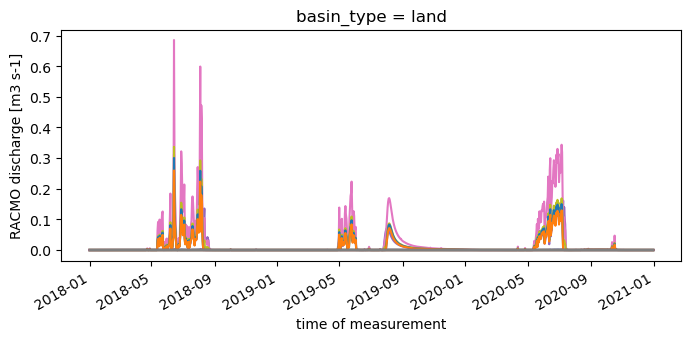

In [10]:
rink_racmo_ds.sel(basin_type='land').discharge.plot.line(hue='station', add_legend=None, figsize=[8,3]);

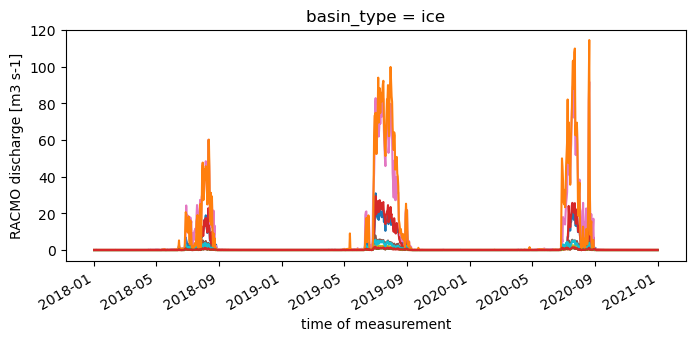

In [11]:
rink_racmo_ds.sel(basin_type='ice').discharge.plot.line(hue='station', add_legend=None, figsize=[8,3]);

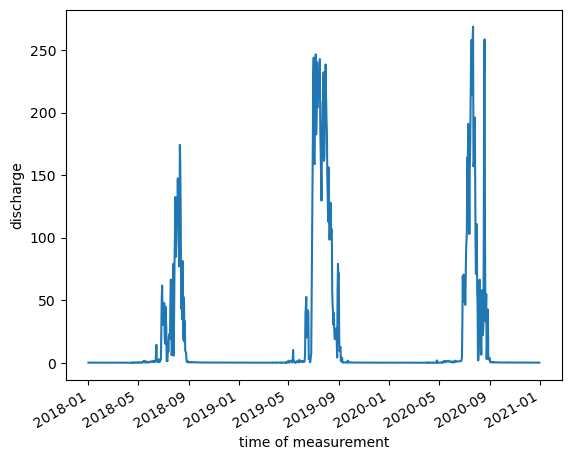

In [18]:
rink_racmo_ds.sum(dim=['basin_type','station']).discharge.plot();

In [145]:
# which outlets contribute the most to the annual discharge?
rink_racmo_ice_max = rink_racmo_ice.max('time')
rink_racmo_ice_max_select = rink_racmo_ice_max.where(rink_racmo_ice_max > 40, drop=True)

# transform these coords to polar
x_max, y_max = transform_projection_to_Npolar(rink_racmo_ice_max_select)

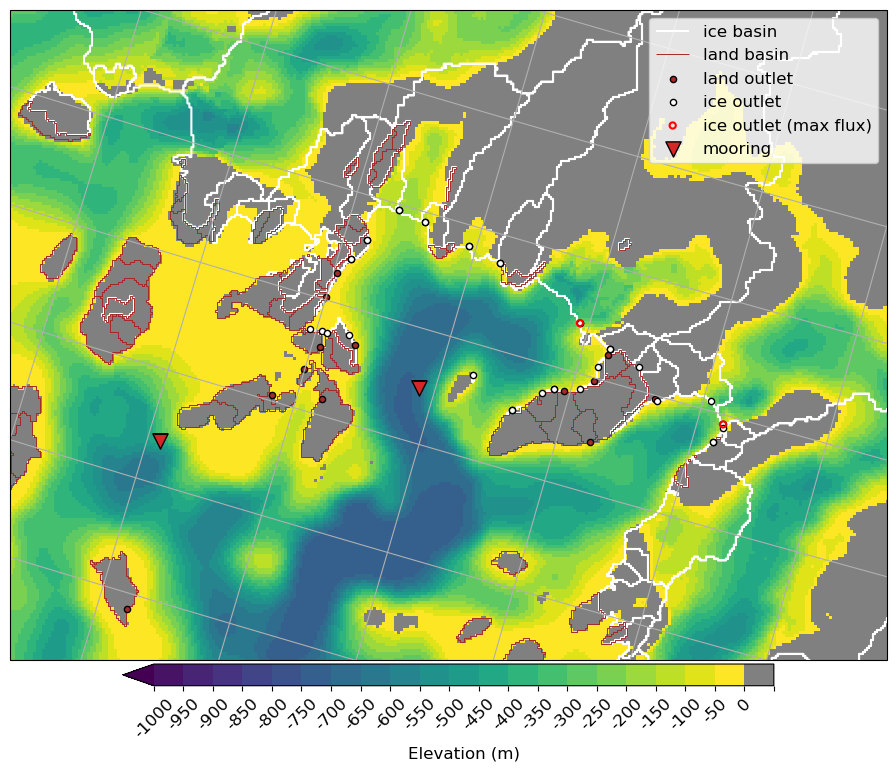

In [73]:
fig = plt.figure(figsize=(12,10))
plt.rcParams['font.size'] = '12'
ax = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -45))
ax.set_extent([-62, -60.5, 76.5, 76.7], ccrs.PlateCarree())

# define top and bottom colormaps 
bathy = cm.get_cmap('viridis', 21)
surface = (.5, .5, .5, 1.0)
newcolors = np.vstack((bathy(np.linspace(0, 1, 21)),
                       surface)) # create a new colormaps
ocean_land = ListedColormap(newcolors, name='ocean_land')
bounds = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0,0.1]
ticks = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0,0.1]

pc = bed_masked_ds.plot.pcolormesh('x','y',ax=ax,transform=ccrs.NorthPolarStereo(central_longitude = -45),\
                                   shading='auto',rasterized=True,cmap=ocean_land,levels=bounds,add_colorbar=False)
cbar = plt.colorbar(pc, label='Elevation (m)',ticks=ticks,boundaries=bounds,orientation='horizontal',\
                    shrink=0.7,spacing='uniform',pad=0.005,aspect=30)
cbar.ax.set_xticklabels(np.append(ticks[:-1], ''),rotation=45)

# ax.coastlines(linewidths=0.7)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)

# plot basin outlines
basins_ice.boundary.plot(ax=ax, color='white', transform=ccrs.NorthPolarStereo(central_longitude = -45), zorder=1, label='ice basin')
basins_land.boundary.plot(ax=ax, color='brown', linewidth=0.7, transform=ccrs.NorthPolarStereo(central_longitude = -45), zorder=1, label='land basin')

# plot selected outlet locations
# plt.scatter(x_racmo, y_racmo,marker='o',edgecolors='k',s=colors,transform=ccrs.NorthPolarStereo(central_longitude = -45))
plt.scatter(x_land, y_land,marker='o',color='brown',s=20,edgecolors='k',transform=ccrs.NorthPolarStereo(central_longitude = -45), label='land outlet')
plt.scatter(x_ice, y_ice,marker='o',color='white',s=20,edgecolors='k',transform=ccrs.NorthPolarStereo(central_longitude = -45), label='ice outlet')
plt.scatter(x_max, y_max,marker='o',s=20,facecolors='none',edgecolors='r',linewidth=1.5,transform=ccrs.NorthPolarStereo(central_longitude = -45), label='ice outlet (max flux)')

# add mooring locations
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3413', always_xy=True)
x_rink, y_rink = transformer.transform(-61.279117, 76.160533)
x_fisher, y_fisher = transformer.transform(-61.726983, 76.103817)

ax.scatter(x_rink, y_rink, s=120, c='tab:red',edgecolor='black',marker="v",transform=ccrs.NorthPolarStereo(central_longitude = -45), label='mooring')
ax.scatter(x_fisher, y_fisher, s=120, c='tab:red',edgecolor='black',marker="v",transform=ccrs.NorthPolarStereo(central_longitude = -45));

ax.legend(loc='upper right');

# plt.savefig("Figures/sverdrup_ridgelines.png", bbox_inches='tight', dpi=300, facecolor='white')

Get runoff depth (at ice basin outlet for glacier)

In [150]:
rink_racmo_ice_max_select

<xarray.Dataset>
Dimensions:     (station: 2)
Coordinates:
  * station     (station) uint64 30604 30702
    lat         (station) float32 76.21 76.18
    lon         (station) float32 -61.02 -60.7
    alt         (station) float32 -250.0 -34.0
    B2015_dist  (station) float64 903.0 8.658e+03
    basin_type  <U3 'ice'
Data variables:
    discharge   (station) float64 92.51 114.6

In [151]:
# runoff depth for glacier
rink_racmo_ice_max_select.isel(station=0).alt.values

array(-250., dtype=float32)

### Kong Oscar glacier

In [48]:
racmo_discharge_ds, mar_discharge_ds = get_freshwater_discharge_data(discharge_data_dir, output_dir, get_years=['2018','2019','2020'],\
                                                                     station_name='Nuussuup Sermia', range_filter='FALSE', range_meters=8000)

query netcdfs:   0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
# load data
ko_racmo_ds = xr.open_dataset('D:/Habitat_model_data/Mankoff_discharge_data/netcdfs/racmo_freshwater_discharge_Nuussuup_Sermia.nc')
ko_mar_ds = xr.open_dataset('D:/Habitat_model_data/Mankoff_discharge_data/netcdfs/mar_freshwater_discharge_Nuussuup_Sermia.nc')

In [161]:
# reproject lat/lon coords to Polar to plot with BedMachine
x_racmo, y_racmo = transform_projection_to_Npolar(ko_racmo_ds)
x_mar, y_mar     = transform_projection_to_Npolar(ko_mar_ds)

In [220]:
# reproject lat/lon coords to Polar to plot with BedMachine
# separate into land and ice basins
ko_racmo_ice = ko_racmo_ds.sel(basin_type='ice')
ko_racmo_land = ko_racmo_ds.sel(basin_type='land')

ko_mar_ice = ko_mar_ds.sel(basin_type='ice')
ko_mar_land = ko_mar_ds.sel(basin_type='land')

x_ice, y_ice = transform_projection_to_Npolar(ko_racmo_ice)
x_land, y_land = transform_projection_to_Npolar(ko_racmo_land)

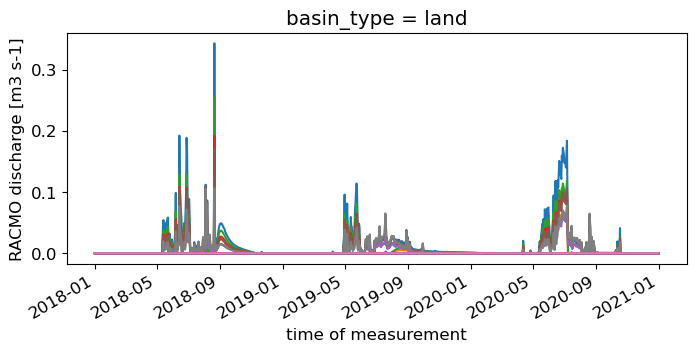

In [84]:
ko_racmo_ds.sel(basin_type='land').discharge.plot.line(hue='station', add_legend=None, figsize=[8,3]);

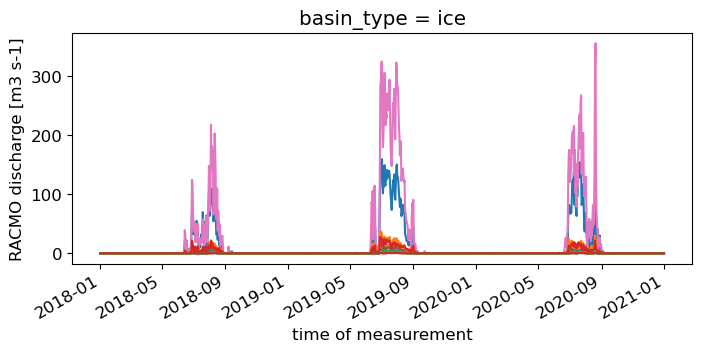

In [85]:
ko_racmo_ds.sel(basin_type='ice').discharge.plot.line(hue='station', add_legend=None, figsize=[8,3]);

In [146]:
# which outlets contribute the most to the annual discharge?
ko_racmo_ice_max = ko_racmo_ice.max('time')
ko_racmo_ice_max_select = ko_racmo_ice_max.where(ko_racmo_ice_max > 50, drop=True)

# transform these coords to polar
x_max, y_max = transform_projection_to_Npolar(ko_racmo_ice_max_select)

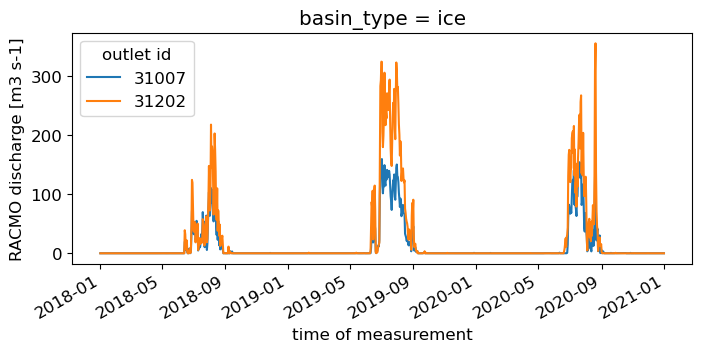

In [158]:
ko_racmo_ice.where(ko_racmo_ice_max > 50, drop=True).discharge.plot.line(hue='station', figsize=[8,3]);

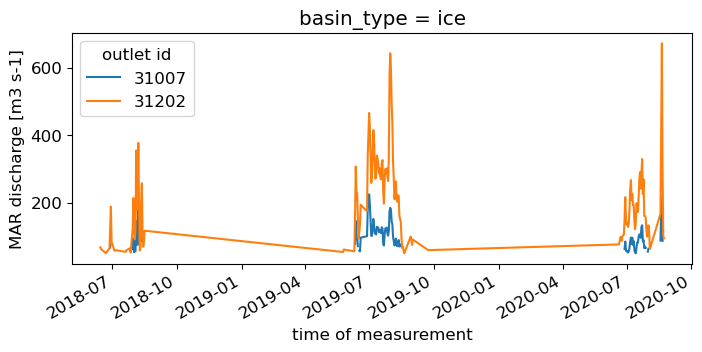

In [221]:
ko_mar_ice.where(ko_mar_ice > 50, drop=True).discharge.plot.line(hue='station', figsize=[8,3]);

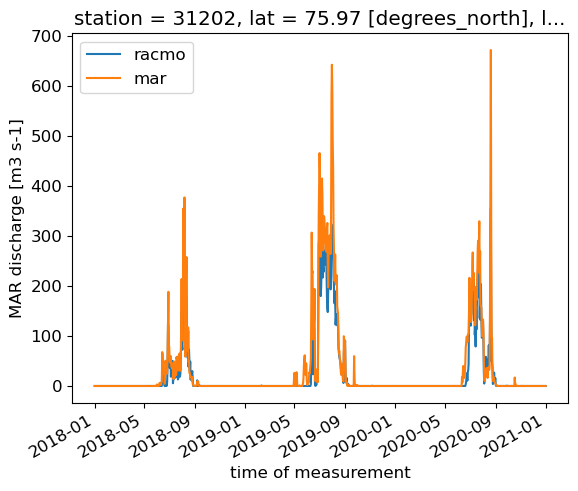

In [226]:
ko_racmo_ice.sel(station=31202).discharge.plot(label='racmo')
ko_mar_ice.sel(station=31202).discharge.plot(label='mar')
plt.legend();

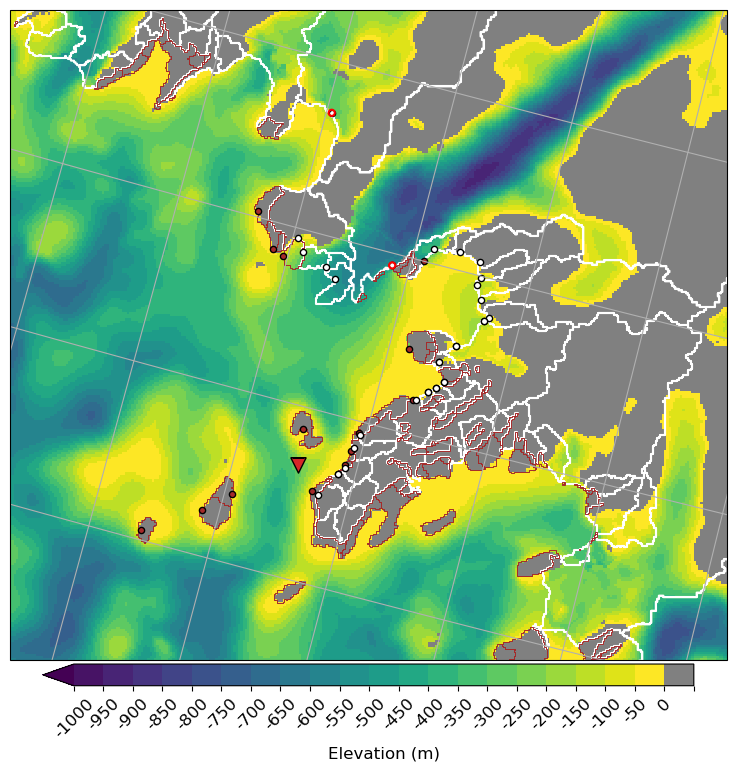

In [59]:
fig = plt.figure(figsize=(12,10))
plt.rcParams['font.size'] = '12'
ax = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -45))
# ax.set_extent([-60.5, -59, 76, 76.6], ccrs.PlateCarree())
ax.set_extent([-60.5, -59, 76.2, 76.5], ccrs.PlateCarree())

# define top and bottom colormaps 
bathy = cm.get_cmap('viridis', 21)
surface = (.5, .5, .5, 1.0)
newcolors = np.vstack((bathy(np.linspace(0, 1, 21)),
                       surface)) # create a new colormaps
ocean_land = ListedColormap(newcolors, name='ocean_land')
bounds = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0,0.1]
ticks = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0,0.1]

pc = bed_masked_ds.plot.pcolormesh('x','y',ax=ax,transform=ccrs.NorthPolarStereo(central_longitude = -45),\
                                   shading='auto',rasterized=True,cmap=ocean_land,levels=bounds,add_colorbar=False)
cbar = plt.colorbar(pc, label='Elevation (m)',ticks=ticks,boundaries=bounds,orientation='horizontal',\
                    shrink=0.7,spacing='uniform',pad=0.005,aspect=30)
cbar.ax.set_xticklabels(np.append(ticks[:-1], ''),rotation=45)

# ax.coastlines(linewidths=0.7)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)

# plot basin outlines
basins_ice.boundary.plot(ax=ax, color='white', transform=ccrs.NorthPolarStereo(central_longitude = -45), zorder=1)
basins_land.boundary.plot(ax=ax, color='brown', linewidth=0.7, transform=ccrs.NorthPolarStereo(central_longitude = -45), zorder=1)

# plot selected outlet locations
# plt.scatter(x_racmo, y_racmo,marker='o',edgecolors='k',s=colors,transform=ccrs.NorthPolarStereo(central_longitude = -45))
plt.scatter(x_land, y_land,marker='o',color='brown',s=20,edgecolors='k',transform=ccrs.NorthPolarStereo(central_longitude = -45))
plt.scatter(x_ice, y_ice,marker='o',color='white',s=20,edgecolors='k',transform=ccrs.NorthPolarStereo(central_longitude = -45))
plt.scatter(x_max, y_max,marker='o',s=20,facecolors='none',edgecolors='r',linewidth=1.5,transform=ccrs.NorthPolarStereo(central_longitude = -45))

# plot mooring location
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3413', always_xy=True)
x_KO, y_KO = transformer.transform(-59.8429, 75.843683)
ax.scatter(x_KO, y_KO, s=120, c='tab:red', edgecolor='black',marker="v",transform=ccrs.NorthPolarStereo(central_longitude = -45));

# plt.savefig("Figures/sverdrup_ridgelines.png", bbox_inches='tight', dpi=300, facecolor='white')

Get runoff depth (at ice basin outlet for glacier)

In [131]:
ko_racmo_ice_max_select

<xarray.Dataset>
Dimensions:     (station: 2)
Coordinates:
  * station     (station) uint64 31007 31202
    lat         (station) float32 76.05 75.97
    lon         (station) float32 -59.99 -59.74
    alt         (station) float32 -282.0 -457.0
    B2015_dist  (station) float64 7.883e+03 3.441e+03
    basin_type  <U3 'ice'
Data variables:
    discharge   (station) float64 159.5 355.6

In [133]:
# runoff depth for glacier
ko_racmo_ice_max_select.isel(station=1).alt.values

array(-457., dtype=float32)

### Sverdrup glacier

In [10]:
racmo_discharge_ds, mar_discharge_ds = get_freshwater_discharge_data(discharge_data_dir, output_dir, get_years=['2018','2019','2020'],\
                                                                     station_name='Sverdrup Gletsjer', range_filter='FALSE', range_meters=8000)

query netcdfs:   0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
# load data
sver_racmo_ds = xr.open_dataset('D:/Habitat_model_data/Mankoff_discharge_data/netcdfs/racmo_freshwater_discharge_Sverdrup_Gletsjer.nc')
sver_mar_ds = xr.open_dataset('D:/Habitat_model_data/Mankoff_discharge_data/netcdfs/mar_freshwater_discharge_Sverdrup_Gletsjer.nc')

In [79]:
tmp = racmo_discharge_ds.where(racmo_discharge_ds.B2015_dist<8000, drop=True)

In [93]:
# reproject lat/lon coords to Polar to plot with BedMachine
x_racmo, y_racmo = transform_projection_to_Npolar(sver_racmo_ds)
x_mar, y_mar     = transform_projection_to_Npolar(sver_mar_ds)

In [227]:
# reproject lat/lon coords to Polar to plot with BedMachine
# separate into land and ice basins
sver_racmo_ice = sver_racmo_ds.sel(basin_type='ice')
sver_racmo_land = sver_racmo_ds.sel(basin_type='land')

sver_mar_ice = sver_mar_ds.sel(basin_type='ice')
sver_mar_land = sver_mar_ds.sel(basin_type='land')

x_ice, y_ice = transform_projection_to_Npolar(sver_racmo_ice)
x_land, y_land = transform_projection_to_Npolar(sver_racmo_land)

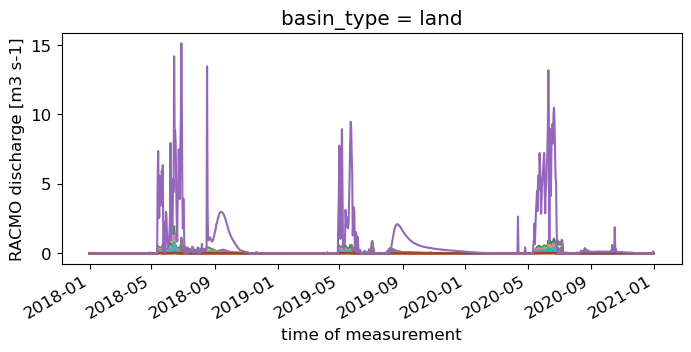

In [96]:
sver_racmo_ds.sel(basin_type='land').discharge.plot.line(hue='station', add_legend=None, figsize=[8,3]);

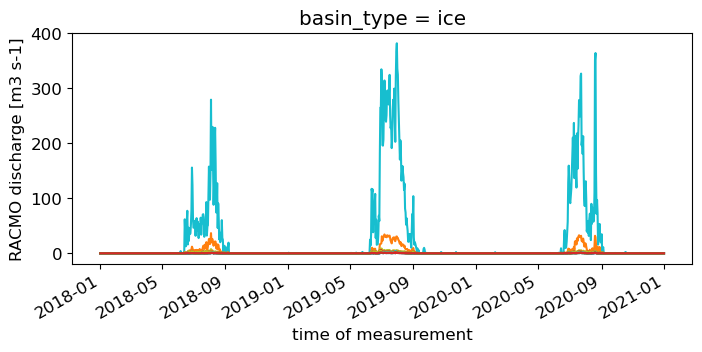

In [98]:
sver_racmo_ds.sel(basin_type='ice').discharge.plot.line(hue='station', add_legend=None, figsize=[8,3]);

In [147]:
# which outlets contribute the most to the annual discharge?
sver_racmo_ice_max = sver_racmo_ice.max('time')
sver_racmo_ice_max_select = sver_racmo_ice_max.where(sver_racmo_ice_max > 50, drop=True)

# transform these coords to polar
x_max, y_max = transform_projection_to_Npolar(sver_racmo_ice_max_select)

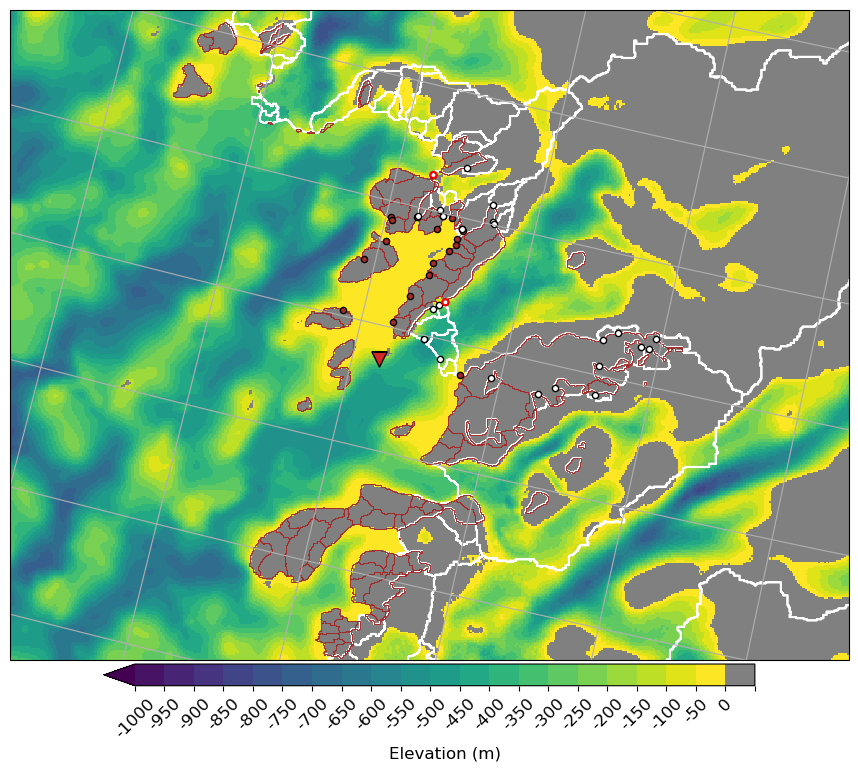

In [47]:
fig = plt.figure(figsize=(12,10))
plt.rcParams['font.size'] = '12'
ax = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -45))
ax.set_extent([-59.5, -57, 75.8, 76.2], ccrs.PlateCarree())

# define top and bottom colormaps 
bathy = cm.get_cmap('viridis', 21)
surface = (.5, .5, .5, 1.0)
newcolors = np.vstack((bathy(np.linspace(0, 1, 21)),
                       surface)) # create a new colormaps
ocean_land = ListedColormap(newcolors, name='ocean_land')
bounds = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0,0.1]
ticks = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0,0.1]

pc = bed_masked_ds.plot.pcolormesh('x','y',ax=ax,transform=ccrs.NorthPolarStereo(central_longitude = -45),\
                                   shading='auto',rasterized=True,cmap=ocean_land,levels=bounds,add_colorbar=False)
cbar = plt.colorbar(pc, label='Elevation (m)',ticks=ticks,boundaries=bounds,orientation='horizontal',\
                    shrink=0.7,spacing='uniform',pad=0.005,aspect=30)
cbar.ax.set_xticklabels(np.append(ticks[:-1], ''),rotation=45)

# ax.coastlines(linewidths=0.7)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)

# plot basin outlines
basins_ice.boundary.plot(ax=ax, color='white', transform=ccrs.NorthPolarStereo(central_longitude = -45), zorder=1)
basins_land.boundary.plot(ax=ax, color='brown', linewidth=0.7, transform=ccrs.NorthPolarStereo(central_longitude = -45), zorder=1)

# plot selected outlet locations
colors = racmo_discharge_ds.max(['time'])
# plt.scatter(x_racmo, y_racmo,marker='o',edgecolors='k',s=colors,transform=ccrs.NorthPolarStereo(central_longitude = -45))
plt.scatter(x_land, y_land,marker='o',color='brown',s=20,edgecolors='k',transform=ccrs.NorthPolarStereo(central_longitude = -45))
plt.scatter(x_ice, y_ice,marker='o',color='white',s=20,edgecolors='k',transform=ccrs.NorthPolarStereo(central_longitude = -45))
plt.scatter(x_max, y_max,marker='o',s=20,facecolors='none',edgecolors='r',linewidth=1.5,transform=ccrs.NorthPolarStereo(central_longitude = -45))

# plot mooring location
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3413', always_xy=True)
x_sver, y_sver = transformer.transform(-58.410533, 75.5413)
ax.scatter(x_sver, y_sver, s=120, c='tab:red', edgecolor='black',marker="v",transform=ccrs.NorthPolarStereo(central_longitude = -45));

# plt.savefig("Figures/sverdrup_ridgelines.png", bbox_inches='tight', dpi=300, facecolor='white')

Get runoff depth (at ice basin outlet for glacier)

In [107]:
sver_racmo_ice_max_select

<xarray.Dataset>
Dimensions:     (station: 1)
Coordinates:
  * station     (station) uint64 31992
    lat         (station) float32 75.6
    lon         (station) float32 -58.24
    alt         (station) float32 -187.0
    B2015_dist  (station) float64 7.643e+03
    basin_type  <U3 'ice'
Data variables:
    discharge   (station) float64 381.7

In [103]:
# runoff depth for glacier
sver_racmo_ice_max_select.isel(station=0).alt.values

array(-187., dtype=float32)

### Calculate mean runoff for summer (June, July, August)

In [202]:
# calculate summer weighted average
def summer_mean(ds):
    summer18 = ds.sel(time=slice('2018-06-01','2018-08-31')).discharge
    summer19 = ds.sel(time=slice('2019-06-01','2019-08-31')).discharge
    summer20 = ds.sel(time=slice('2020-06-01','2020-08-31')).discharge
    
    summer_combined = xr.concat([summer18,summer19,summer20], dim='time')
    
    return summer_combined

#### Rink

In [203]:
rink_racmo_summer = summer_mean(rink_racmo_ice)

In [229]:
rink_mar_summer = summer_mean(rink_mar_ice)

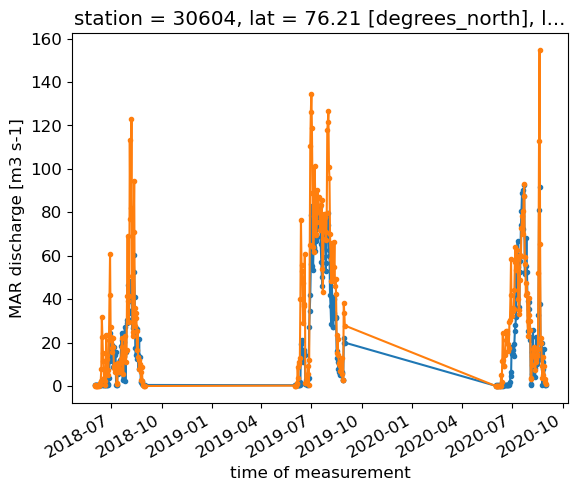

In [238]:
rink_racmo_summer.sel(station=30604).plot(marker='.');
rink_mar_summer.sel(station=30604).plot(marker='.');

In [218]:
rink_racmo_summer.sel(station=30604).mean().values # select rink glacier ice outlet

array(23.88649766)

In [230]:
rink_mar_summer.sel(station=30604).mean().values # select rink glacier ice outlet

array(33.30207105)

In [240]:
rink_racmo_summer.sel(station=30604).alt.values 

array(-250., dtype=float32)

In [239]:
rink_mar_summer.sel(station=30604).alt.values 

array(-250., dtype=float32)

#### Kong Oscar

In [208]:
ko_racmo_summer = summer_mean(ko_racmo_ice)

In [231]:
ko_mar_summer = summer_mean(ko_mar_ice)

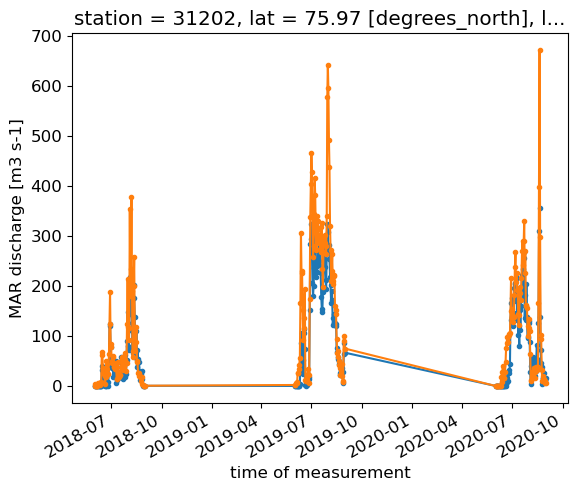

In [237]:
ko_racmo_summer.sel(station=31202).plot(marker='.');
ko_mar_summer.sel(station=31202).plot(marker='.');

In [209]:
ko_racmo_summer.sel(station=31202).mean().values # select kong oscar glacier ice outlet

array(87.72377241)

In [232]:
ko_mar_summer.sel(station=31202).mean().values # select kong oscar glacier ice outlet

array(121.02898055)

In [244]:
ko_racmo_summer.sel(station=31202).alt.values

array(-457., dtype=float32)

In [243]:
ko_mar_summer.sel(station=31202).alt.values

array(-457., dtype=float32)

#### Sverdrup

In [211]:
sver_racmo_summer = summer_mean(sver_racmo_ice)

In [233]:
sver_mar_summer = summer_mean(sver_mar_ice)

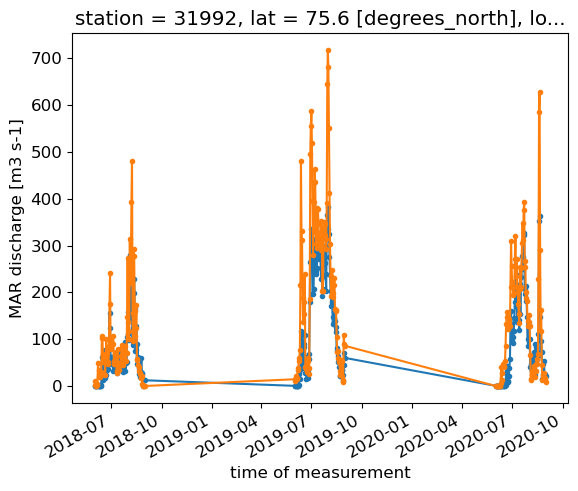

In [236]:
sver_racmo_summer.sel(station=31992).plot(marker='.');
sver_mar_summer.sel(station=31992).plot(marker='.');

In [213]:
sver_racmo_summer.sel(station=31992).mean().values # select sverdrup glacier ice outlet

array(102.16656489)

In [234]:
sver_mar_summer.sel(station=31992).mean().values # select sverdrup glacier ice outlet

array(147.92156435)

In [241]:
sver_racmo_summer.sel(station=31992).alt.values 

array(-187., dtype=float32)

In [242]:
sver_mar_summer.sel(station=31992).alt.values 

array(-187., dtype=float32)

***

## Plot 7-day running mean

In [6]:
# load netCDFs
rink_racmo_ds = xr.open_dataset('netcdfs/racmo_freshwater_discharge_Rink_Gletsjer.nc')
rink_mar_ds = xr.open_dataset('netcdfs/mar_freshwater_discharge_Rink_Gletsjer.nc')

KO_racmo_ds = xr.open_dataset('netcdfs/racmo_freshwater_discharge_Nuussuup_Sermia.nc')
KO_mar_ds = xr.open_dataset('netcdfs/mar_freshwater_discharge_Nuussuup_Sermia.nc')

sver_racmo_ds = xr.open_dataset('netcdfs/racmo_freshwater_discharge_Sverdrup_Gletsjer.nc')
sver_mar_ds = xr.open_dataset('netcdfs/mar_freshwater_discharge_Sverdrup_Gletsjer.nc')

In [44]:
rink_ice = rink_racmo_ds.sel(basin_type='ice').max('time')
rink_ice_max1 = rink_ice.where(rink_ice.discharge > 20, drop=True)
rink_ice_max2 = rink_ice.where(rink_ice.discharge > 50, drop=True)

In [47]:
# station 30604 is the main rink glacier outlet
rink_racmo_ds.sel(basin_type='ice').sel(station=30604)

<xarray.Dataset>
Dimensions:     (time: 1096)
Coordinates:
    station     uint64 30604
  * time        (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2020-12-31
    lat         float32 76.21
    lon         float32 -61.02
    alt         float32 -250.0
    B2015_dist  float64 903.0
    basin_type  <U3 'ice'
Data variables:
    discharge   (time) float64 ...

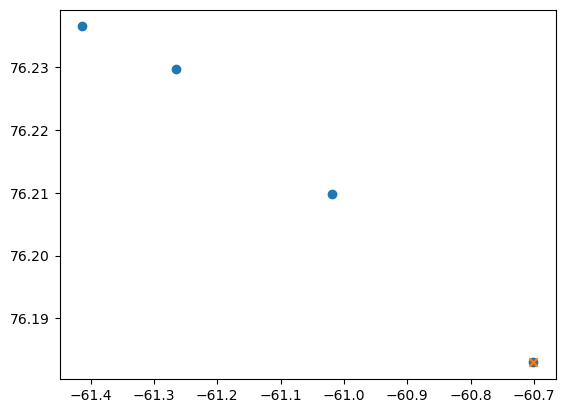

In [42]:
plt.scatter(rink_ice_max1.lon, rink_ice_max1.lat)
plt.scatter(rink_ice_max2.lon, rink_ice_max2.lat, marker='x')

Include a 7-day running mean based on:<br>
"RCM runoff is summed over each basin for each day of RCM data and assigned to each outlet for that day. This assumes routing between the runoff and the outlet is instantaneous, so  all  analyses  done  here  include  a  7 d  smooth  applied  to the  RCM  discharge  product  (cf.  van  As  et  al.,  2017).  The released data do not include any smoothing." from paper

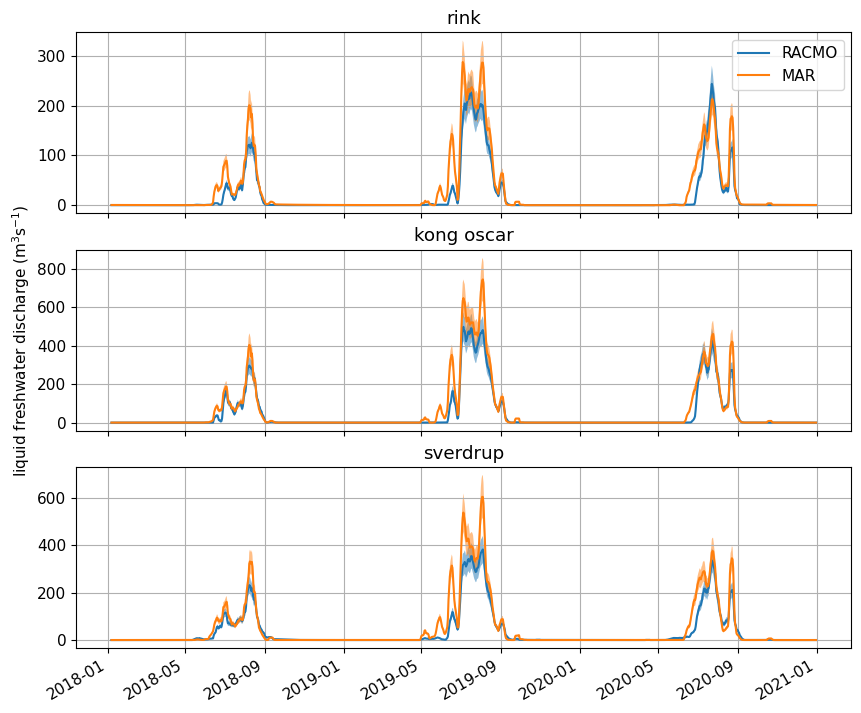

In [120]:
fig, axs = plt.subplots(3)
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['font.size'] = 11

rink_racmo_7d = rink_racmo_ds.discharge.sum(dim=['station','basin_type']).rolling(time=7).mean()
rink_racmo_7d.plot(ax=axs[0], label='RACMO')
rink_mar_7d = rink_mar_ds.discharge.sum(dim=['station','basin_type']).rolling(time=7).mean()
rink_mar_7d.plot(ax=axs[0], label='MAR')
# add 15% error
axs[0].fill_between(rink_racmo_7d.time.values, rink_racmo_7d+rink_racmo_7d*0.15, rink_racmo_7d-rink_racmo_7d*0.15, alpha=0.5)
axs[0].fill_between(rink_mar_7d.time.values, rink_mar_7d+rink_mar_7d*0.15, rink_mar_7d-rink_mar_7d*0.15, alpha=0.5)
axs[0].set_title("rink")
axs[0].xaxis.set_ticklabels([])
axs[0].set_xlabel("")
axs[0].set_ylabel("")
axs[0].grid()
axs[0].legend()

KO_racmo_7d = KO_racmo_ds.discharge.sum(dim=['station','basin_type']).rolling(time=7).mean()
KO_racmo_7d.plot(ax=axs[1])
KO_mar_7d = KO_mar_ds.discharge.sum(dim=['station','basin_type']).rolling(time=7).mean()
KO_mar_7d.plot(ax=axs[1])
# add 15% error
axs[1].fill_between(KO_racmo_7d.time.values, KO_racmo_7d+KO_racmo_7d*0.15, KO_racmo_7d-KO_racmo_7d*0.15, alpha=0.5)
axs[1].fill_between(KO_mar_7d.time.values, KO_mar_7d+KO_mar_7d*0.15, KO_mar_7d-KO_mar_7d*0.15, alpha=0.5)
axs[1].set_title("kong oscar")
axs[1].xaxis.set_ticklabels([])
axs[1].set_xlabel("")
axs[1].set_ylabel("liquid freshwater discharge (m$^3$s$^{-1}$)")
axs[1].grid()

sver_racmo_7d = sver_racmo_ds.discharge.sum(dim=['station','basin_type']).rolling(time=7).mean()
sver_racmo_7d.plot(ax=axs[2])
sver_mar_7d = sver_mar_ds.discharge.sum(dim=['station','basin_type']).rolling(time=7).mean()
sver_mar_7d.plot(ax=axs[2])
# add 15% error
axs[2].fill_between(sver_racmo_7d.time.values, sver_racmo_7d+sver_racmo_7d*0.15, sver_racmo_7d-sver_racmo_7d*0.15, alpha=0.5)
axs[2].fill_between(sver_mar_7d.time.values, sver_mar_7d+sver_mar_7d*0.15, sver_mar_7d-sver_mar_7d*0.15, alpha=0.5)
axs[2].set_ylabel("")
axs[2].set_xlabel("")
axs[2].set_title("sverdrup")
axs[2].grid();

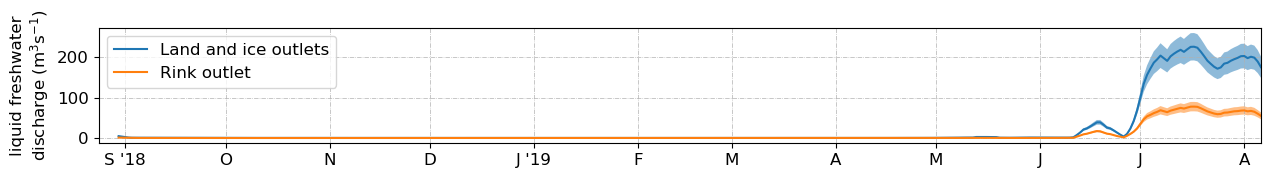

In [15]:
# plot rink
plt.rcParams["figure.figsize"] = (15,1.5)
plt.rcParams['font.size'] = 12

months = pd.period_range(np.datetime64('2018-09'), freq='M', periods=12).strftime('%Y-%m').tolist()
ticks = ["S '18","O",'N','D',"J '19",'F','M','A','M','J','J','A']

rink_racmo_7d = rink_racmo_ds.sel(time=slice("2018-08-24","2019-08-06")).discharge.sum(dim=['station','basin_type']).rolling(time=7).mean()
rink_racmo_7d.plot(label='Land and ice outlets')

rink_glacier_racmo_7d = rink_racmo_ds.sel(station=30604,time=slice("2018-08-24","2019-08-06")).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
rink_glacier_racmo_7d.plot(label='Rink outlet')

# add 15% error
plt.fill_between(rink_racmo_7d.time.values, rink_racmo_7d+rink_racmo_7d*0.15, rink_racmo_7d-rink_racmo_7d*0.15, alpha=0.5)
plt.fill_between(rink_glacier_racmo_7d.time.values, rink_glacier_racmo_7d+rink_glacier_racmo_7d*0.15,\
                 rink_glacier_racmo_7d-rink_glacier_racmo_7d*0.15, alpha=0.5)

# plt.title("kong oscar")
plt.xlabel("")
plt.title("")
plt.ylabel("liquid freshwater\ndischarge (m$^3$s$^{-1}$)")
plt.xticks(months, ticks, rotation=0, horizontalalignment = 'center')
plt.xlim(np.datetime64("2018-08-24"),np.datetime64("2019-08-06"))
plt.grid(linestyle='-.', linewidth=0.5)
plt.legend(loc="upper left");

# plt.savefig("../code/figures/fjord_subplots/KO_runoff.png", bbox_inches="tight", dpi=300)

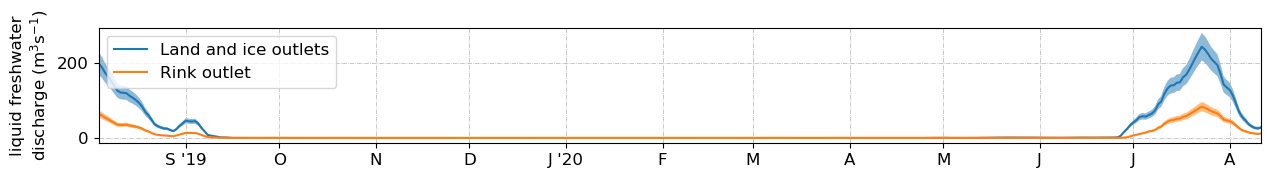

In [18]:
# plot fisher
plt.rcParams["figure.figsize"] = (15,1.5)
plt.rcParams['font.size'] = 12

months = pd.period_range(np.datetime64('2019-09'), freq='M', periods=12).strftime('%Y-%m').tolist()
ticks = ["S '19","O",'N','D',"J '20",'F','M','A','M','J','J','A']

rink_racmo_7d = rink_racmo_ds.sel(time=slice("2019-07-25","2020-08-11")).discharge.sum(dim=['station','basin_type']).rolling(time=7).mean()
rink_racmo_7d.plot(label='Land and ice outlets')

rink_glacier_racmo_7d = rink_racmo_ds.sel(station=30604,time=slice("2019-07-25","2020-08-11")).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
rink_glacier_racmo_7d.plot(label='Rink outlet')

# add 15% error
plt.fill_between(rink_racmo_7d.time.values, rink_racmo_7d+rink_racmo_7d*0.15, rink_racmo_7d-rink_racmo_7d*0.15, alpha=0.5)
plt.fill_between(rink_glacier_racmo_7d.time.values, rink_glacier_racmo_7d+rink_glacier_racmo_7d*0.15,\
                 rink_glacier_racmo_7d-rink_glacier_racmo_7d*0.15, alpha=0.5)

# plt.title("kong oscar")
plt.xlabel("")
plt.title("")
plt.ylabel("liquid freshwater\ndischarge (m$^3$s$^{-1}$)")
plt.xticks(months, ticks, rotation=0, horizontalalignment = 'center')
plt.xlim(np.datetime64("2019-08-04"),np.datetime64("2020-08-11"))
plt.grid(linestyle='-.', linewidth=0.5)
plt.legend(loc="upper left");

# plt.savefig("../code/figures/fjord_subplots/KO_runoff.png", bbox_inches="tight", dpi=300)

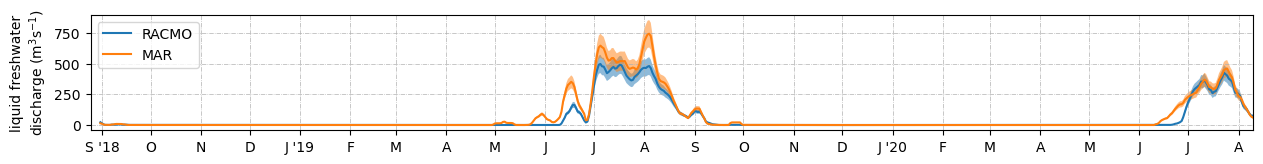

In [27]:
# plot Kong Oscar MAR and RACMO
plt.rcParams["figure.figsize"] = (15,1.5)
plt.rcParams['font.size'] = 10

months = pd.period_range(np.datetime64('2018-09'), freq='M', periods=24).strftime('%Y-%m').tolist()
ticks = ["S '18","O",'N','D',"J '19",'F','M','A','M','J','J','A','S','O','N','D',"J '20",'F','M','A','M','J','J','A']

KO_racmo_7d = KO_racmo_ds.sel(time=slice("2018-08-25","2020-08-10")).discharge.sum(dim=['station','basin_type']).rolling(time=7).mean()
KO_racmo_7d.plot(label='RACMO')
KO_mar_7d = KO_mar_ds.sel(time=slice("2018-08-25","2020-08-10")).discharge.sum(dim=['station','basin_type']).rolling(time=7).mean()
KO_mar_7d.plot(label='MAR')
# add 15% error
plt.fill_between(KO_racmo_7d.time.values, KO_racmo_7d+KO_racmo_7d*0.15, KO_racmo_7d-KO_racmo_7d*0.15, alpha=0.5)
plt.fill_between(KO_mar_7d.time.values, KO_mar_7d+KO_mar_7d*0.15, KO_mar_7d-KO_mar_7d*0.15, alpha=0.5)
# plt.title("kong oscar")
plt.xlabel("")
plt.ylabel("liquid freshwater\ndischarge (m$^3$s$^{-1}$)")
plt.xticks(months, ticks, rotation=0, horizontalalignment = 'center')
plt.xlim([np.datetime64("2018-08-25"),np.datetime64("2020-08-10")])
plt.grid(linestyle='-.', linewidth=0.5)
plt.legend(loc="upper left")

plt.savefig("../code/figures/fjord_subplots/KO_runoff.png", bbox_inches="tight", dpi=300)

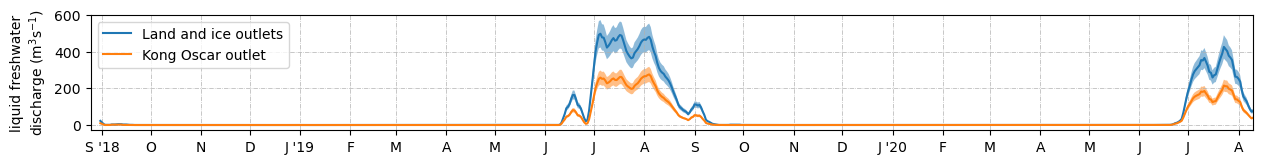

In [16]:
# plot Kong Oscar RACMO (all + just glacier outlet)
plt.rcParams["figure.figsize"] = (15,1.5)
plt.rcParams['font.size'] = 10

months = pd.period_range(np.datetime64('2018-09'), freq='M', periods=24).strftime('%Y-%m').tolist()
ticks = ["S '18","O",'N','D',"J '19",'F','M','A','M','J','J','A','S','O','N','D',"J '20",'F','M','A','M','J','J','A']

KO_racmo_7d = KO_racmo_ds.sel(time=slice("2018-08-25","2020-08-10")).discharge.sum(dim=['station','basin_type']).rolling(time=7).mean()
KO_racmo_7d.plot(label='Land and ice outlets')

KO_glacier_racmo_7d = KO_racmo_ds.sel(station=31202,time=slice("2018-08-25","2020-08-10")).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
KO_glacier_racmo_7d.plot(label='Kong Oscar outlet')

# add 15% error
plt.fill_between(KO_racmo_7d.time.values, KO_racmo_7d+KO_racmo_7d*0.15, KO_racmo_7d-KO_racmo_7d*0.15, alpha=0.5)
plt.fill_between(KO_glacier_racmo_7d.time.values, KO_glacier_racmo_7d+KO_glacier_racmo_7d*0.15, KO_glacier_racmo_7d-KO_glacier_racmo_7d*0.15, alpha=0.5)

# plt.title("kong oscar")
plt.xlabel("")
plt.title("")
plt.ylabel("liquid freshwater\ndischarge (m$^3$s$^{-1}$)")
plt.xticks(months, ticks, rotation=0, horizontalalignment = 'center')
plt.xlim([np.datetime64("2018-08-25"),np.datetime64("2020-08-10")])
plt.grid(linestyle='-.', linewidth=0.5)
plt.legend(loc="upper left");

# plt.savefig("../code/figures/fjord_subplots/KO_runoff.png", bbox_inches="tight", dpi=300)

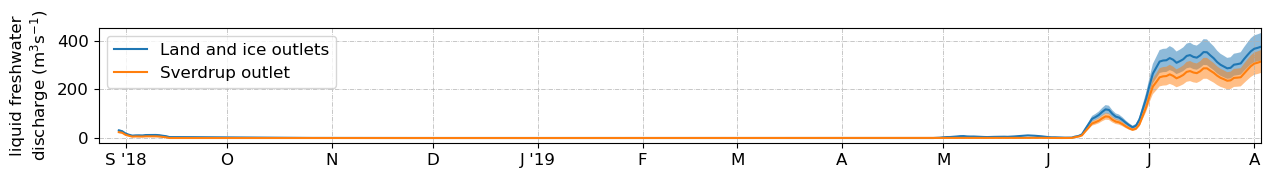

In [14]:
# plot sverdrup
plt.rcParams["figure.figsize"] = (15,1.5)
plt.rcParams['font.size'] = 12

months = pd.period_range(np.datetime64('2018-09'), freq='M', periods=12).strftime('%Y-%m').tolist()
ticks = ["S '18","O",'N','D',"J '19",'F','M','A','M','J','J','A']

sver_racmo_7d = sver_racmo_ds.sel(time=slice("2018-08-24","2019-08-03")).discharge.sum(dim=['station','basin_type']).rolling(time=7).mean()
sver_racmo_7d.plot(label='Land and ice outlets')

sver_glacier_racmo_7d = sver_racmo_ds.sel(station=31992,time=slice("2018-08-24","2019-08-03")).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
sver_glacier_racmo_7d.plot(label='Sverdrup outlet')

# add 15% error
plt.fill_between(sver_racmo_7d.time.values, sver_racmo_7d+sver_racmo_7d*0.15, sver_racmo_7d-sver_racmo_7d*0.15, alpha=0.5)
plt.fill_between(sver_glacier_racmo_7d.time.values, sver_glacier_racmo_7d+sver_glacier_racmo_7d*0.15,\
                 sver_glacier_racmo_7d-sver_glacier_racmo_7d*0.15, alpha=0.5)

# plt.title("kong oscar")
plt.xlabel("")
plt.title("")
plt.ylabel("liquid freshwater\ndischarge (m$^3$s$^{-1}$)")
plt.xticks(months, ticks, rotation=0, horizontalalignment = 'center')
plt.xlim([np.datetime64("2018-08-24"),np.datetime64("2019-08-03")])
plt.grid(linestyle='-.', linewidth=0.5)
plt.legend(loc="upper left");

# plt.savefig("../code/figures/fjord_subplots/KO_runoff.png", bbox_inches="tight", dpi=300)

## Plot raw data and running mean - RACMO

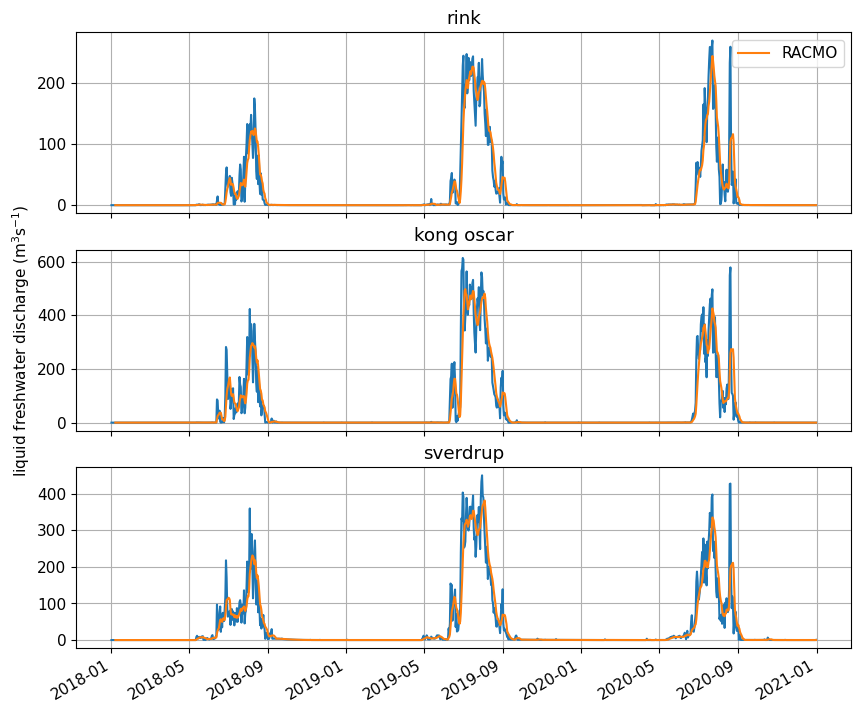

In [32]:
fig, axs = plt.subplots(3)
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['font.size'] = 11

# raw data
rink_racmo_ds.sum(dim=['basin_type','station']).discharge.plot(ax=axs[0])
# running mean
rink_racmo_7d = rink_racmo_ds.discharge.sum(dim=['station','basin_type']).rolling(time=7).mean()
rink_racmo_7d.plot(ax=axs[0], label='RACMO')
axs[0].set_title("rink")
axs[0].xaxis.set_ticklabels([])
axs[0].set_xlabel("")
axs[0].set_ylabel("")
axs[0].grid()
axs[0].legend()

# raw data
KO_racmo_ds.sum(dim=['basin_type','station']).discharge.plot(ax=axs[1])
# running mean
KO_racmo_7d = KO_racmo_ds.discharge.sum(dim=['station','basin_type']).rolling(time=7).mean()
KO_racmo_7d.plot(ax=axs[1])
axs[1].set_title("kong oscar")
axs[1].xaxis.set_ticklabels([])
axs[1].set_xlabel("")
axs[1].set_ylabel("liquid freshwater discharge (m$^3$s$^{-1}$)")
axs[1].grid()

# raw data
sver_racmo_ds.sum(dim=['basin_type','station']).discharge.plot(ax=axs[2])
# running mean
sver_racmo_7d = sver_racmo_ds.discharge.sum(dim=['station','basin_type']).rolling(time=7).mean()
sver_racmo_7d.plot(ax=axs[2])
axs[2].set_ylabel("")
axs[2].set_xlabel("")
axs[2].set_title("sverdrup")
axs[2].grid();

In [34]:
sver_racmo_ds.sum(dim=['basin_type','station']).discharge.values

array([0.09904254, 0.09572087, 0.09706661, ..., 0.09489611, 0.09313232,
       0.60780007])

In [14]:
# create dataframes and export csv files - RACMO
rink_runoff_racmo_df_1D   = pd.DataFrame({'time': rink_racmo_ds.time.values,\
                                    'runoff': rink_racmo_ds.sum(dim=['basin_type','station']).discharge.values})
ko_runoff_racmo_df_1D     = pd.DataFrame({'time': ko_racmo_ds.time.values,\
                                    'runoff': ko_racmo_ds.sum(dim=['basin_type','station']).discharge.values})
sver_runoff_racmo_df_1D   = pd.DataFrame({'time': sver_racmo_ds.time.values,\
                                    'runoff': sver_racmo_ds.sum(dim=['basin_type','station']).discharge.values})

rink_runoff_racmo_df_1D.to_csv('D:/Habitat_model_data/covariate_csv_files/runoff/rink_runoff_racmo_1D.csv', index=False)
ko_runoff_racmo_df_1D.to_csv('D:/Habitat_model_data/covariate_csv_files/runoff/kongoscar_runoff_racmo_1D.csv', index=False)
sver_runoff_racmo_df_1D.to_csv('D:/Habitat_model_data/covariate_csv_files/runoff/sverdrup_runoff_racmo_1D.csv', index=False)

In [15]:
# create dataframes and export csv files - MAR
rink_runoff_mar_df_1D   = pd.DataFrame({'time': rink_mar_ds.time.values,\
                                    'runoff': rink_mar_ds.sum(dim=['basin_type','station']).discharge.values})
ko_runoff_mar_df_1D     = pd.DataFrame({'time': ko_mar_ds.time.values,\
                                    'runoff': ko_mar_ds.sum(dim=['basin_type','station']).discharge.values})
sver_runoff_mar_df_1D   = pd.DataFrame({'time': sver_mar_ds.time.values,\
                                    'runoff': sver_mar_ds.sum(dim=['basin_type','station']).discharge.values})

rink_runoff_mar_df_1D.to_csv('D:/Habitat_model_data/covariate_csv_files/runoff/rink_runoff_mar_1D.csv', index=False)
ko_runoff_mar_df_1D.to_csv('D:/Habitat_model_data/covariate_csv_files/runoff/kongoscar_runoff_mar_1D.csv', index=False)
sver_runoff_mar_df_1D.to_csv('D:/Habitat_model_data/covariate_csv_files/runoff/sverdrup_runoff_mar_1D.csv', index=False)

In [40]:
rink_runoff_df_1D

,time,runoff
0,2018-01-01,0.268265
1,2018-01-02,0.263525
2,2018-01-03,0.271476
3,2018-01-04,0.261517
4,2018-01-05,0.418945
...,...,...
1091,2020-12-27,0.301566
1092,2020-12-28,0.299113
1093,2020-12-29,0.296747
1094,2020-12-30,0.297136
